Student Name : Robert Joseph

Student Id : 1642382

In [ ]:
import numpy as np
import cv2
import os
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.nn import functional as F


**Note : Read**

In this notebook colab gpu was not used instead local gpu as there was an error of cuda illegal memory access so all the relevant lines have been comented and the training took 6 hours for 100 epochs on MX 150 Graphics card.
Hence a slow model and couldnt test it further




# Utils

In [ ]:
def add_noise(imgs):
    """
    Main function add noise to images.

    Here we load the dataset, add gaussian, poisson, speckle
    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    """
    row, col = 28, 28
    noisy_output = np.zeros((len(imgs), row, col))
    
    # adding noise
    for idx, img in enumerate(imgs):
        img = img.astype(np.float32)
        noise_type = random.choice(["gaussian", "speckle"])

        if noise_type == "gaussian":
            mean, var = -10, 100
            sigma = var**.5
            noise = np.random.normal(20, 10, img.shape)
            img += noise

        elif noise_type == "speckle":
            noise = np.random.randn(row,col)
            noise = noise.reshape(row,col)
            img += img * noise


        noisy_output[idx] = img
        
    return noisy_output

# Load and Split Data

In [ ]:
# Loading the dataset from Keras
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=10000, random_state=42)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f"Number of Training Set datapoints: {len(xtrain)}")
print(f"Number of Validation Set datapoints: {len(xval)}")
print(f"Number of Test Set datapoints: {len(xtest)}")

Number of Training Set datapoints: 50000
Number of Validation Set datapoints: 10000
Number of Test Set datapoints: 10000


## Add Noise

In [ ]:
"""
Split Data and Add Noise

We split the 50k training data into 2 sets where we add 1 type of noise to each set. 
"""
import random

# We define two types of noises
noise_types = ["gaussian","speckle"]

# adding noise to xtrain and xtest
noisy_xtrain = add_noise(xtrain)
noisy_xval = add_noise(xval)
noisy_xtest = add_noise(xtest)

## Visualize Noise

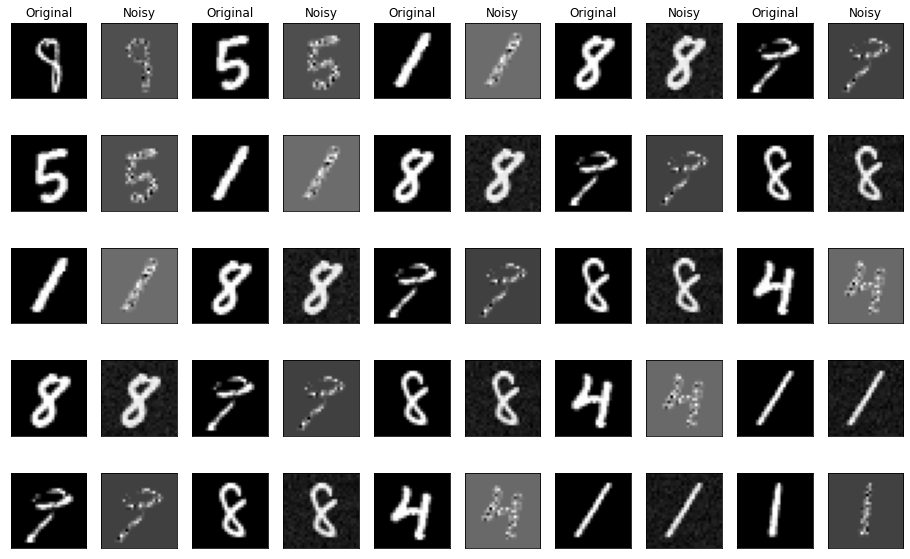

In [ ]:
"""
Visualization of Original Image vs. Noisy Image.
"""
import itertools
f, axes = plt.subplots(5, 10, figsize=(16, 10))

for xid, yid in itertools.product(range(5), range(0, 10, 2)):
    # display original image
    axes[xid, yid].imshow(xtrain[xid+yid//2],cmap="gray")
    axes[xid, yid].set(xticks = [], yticks = [])

    # display original image
    axes[xid, yid+1].imshow(noisy_xtrain[xid+yid//2],cmap="gray")
    axes[xid, yid+1].set(xticks = [], yticks = [])
    
    if xid == 0:
        axes[xid, yid].set(title = "Original")
        axes[xid, yid+1].set(title = "Noisy")

## Data Loader

In [ ]:
"""
Dataset
"""
class noisedDataset(Dataset):
  
    def __init__(self, noisy_dataset, clean_dataset, labels, transform):
        self.noise = noisy_dataset
        self.clean = clean_dataset
        self.labels = labels
        self.transform = transform
  
    def __len__(self):
        return len(self.noise)
  
    def __getitem__(self,idx):
        noisy_x = self.noise[idx]
        clean_x = self.clean[idx]
        y = self.labels[idx]
    
        if self.transform != None:
            noisy_x = self.transform(noisy_x)
            clean_x = self.transform(clean_x)

        return (noisy_x, clean_x, y)  

In [ ]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(noisy_xtrain, xtrain, ytrain, tsfms)
valset = noisedDataset(noisy_xval, xval, yval, tsfms)
testset = noisedDataset(noisy_xtest, xtest, ytest, tsfms)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=True)
print(len(val_dataloader.dataset))

10000


# Denoising Autoencoder (DAE) Model

In [ ]:
"""
Autoencoder model
"""
# TODO: Main model definition + any utilities or custom layers
class DAE(nn.Module):
  """
  DAE Class
  Constructor + Function
  Denoising Autoencoder (DAE) Model
  The denoising autoencoder gets trained to use a hidden layer to reconstruct a particular model based on its inputs.
  Inplace = true was used so that the input is modified directly plus this saves the memory as the Space Complexity does not get increased
  """
  def __init__(self):
    """
    Reference : https://arxiv.org/pdf/1909.10702.pdf
    Paper used CNN and although it ac
    Constructor of the DAE Class
    A Multiple Linear Regression Model was constructed which when trained on 100 epochs resulted in a 65 db model
    Takes in two sequential models
      1 - Encoder 
        1.1 - Linear Model from 28*28 - 10
      2 - Decoder
        2.1 - Linear Model from 10 - 28*28
    At  the end of the decoder model a non linear activation function was added specifically tanh 
    Tanh resulted in less PSNR value compared to Sigmoid

    Parameters : None

    Return : None
    """
    super(DAE,self).__init__()

    # Encoder Container
    self.encoder_model = nn.Sequential(
                  nn.Linear(28*28,512),
                  nn.ReLU(inplace = True),
                
                  nn.Linear(512,256),
                  nn.ReLU(inplace = True),

                  nn.Linear(256,180),
                  nn.ReLU(inplace = True),

                  nn.Linear(180,128),
                  nn.ReLU(inplace = True),

                  nn.Linear(128,64),
                  nn.ReLU(inplace = True))
    
    # Decoder Container
    self.decoder_model = nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),

                  nn.Linear(128,180),
                  nn.ReLU(True),

                  nn.Linear(180,256),
                  nn.ReLU(True),

                  nn.Linear(256,512),
                  nn.ReLU(True),

                  nn.Linear(512,28*28),

                  nn.Sigmoid())


  def forward(self,x):
    """
    This function computes the forward pass of the function
    Used Sigmoid to construct a Linear Regression model

    Parameters : x

    Return : Output
    """
    # Encoder and Decoder 
    output = self.decoder_model((self.encoder_model(x)))
    
    return output


# Training

In [ ]:
def train(train_dataloader, val_dataloader, device, config):
  """
  Training and Validating the Model
  This function uses MSE loss 
  Further more epoch_loss list gets updated with each mean validation loss in every epoch
  
  Parameters : train_dataloader, val_dataloader, device, config

  Return : model, epochs_loss
  """
  # epochs_loss is losses for epochs --> len(epochs_loss) = number of epochs
  epochs_loss = []

  # Defining the Model
  #if torch.cuda.is_available():
  #model=DAE().to(device)
  model = DAE()
  
  # DAE model uses MSE Loss 
  criterion=nn.MSELoss()

  # Optimizer was set to be Adam than SGD due to faster convergence
  # Amsgrad was set to true based on the paper Adam and Beyond
  optimizer = torch.optim.Adam(model.parameters() ,lr = config['learning_rate'], weight_decay = config['weight_decay'])

  log_interval = 521
  losses = 0
  # Epoch Range function defined
  for epoch in range(config['num_epochs']):
    
    # Iterate over the length of the train_dataloader
    for batch_index in range(len(train_dataloader)):
    
      # Get the iterable items from the Dataloader
      noisy_images,clean_images,labels = next(iter(train_dataloader))

      # Convert the tensor images to type float as the images are in type Double
      noisy_images = noisy_images.type(torch.FloatTensor)
      clean_images = clean_images.type(torch.FloatTensor)

      # Create a view ie another tensor and reshape it
      # Fast memory deallocation without device synchronizations
      noisy_images = noisy_images.view(noisy_images.size(0),-1)
      clean_images = clean_images.view(clean_images.size(0),-1)

      # Find the predictions of the noisy images
      output=model(noisy_images)

      # MSE loss is calculated
      # Regularization is already added in our optimizer 
      # Weight Decay = L2 Regularization
      loss=criterion(output,clean_images)

      # Back Propagation
      optimizer.zero_grad()
      loss.backward()

      # Gradient Descent
      optimizer.step()

      # For each log interval print out the Training details ie : Epoch, Loss 
      # .format formats the output in the specific way we want it to be and 0.6f means 6 values after the decimal
      if (batch_index % log_interval) == 0:
        print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # validation 
    
    # Initalize the variables
    validation_loss = 0

    # Set all the operations to have no gradient
    with torch.no_grad():

      # Iterate over the length of the val_dataloader
      for batch_index in range(len(val_dataloader)):
        
        # Get the iterable items from the Dataloader
        noisy_images,clean_images,labels = next(iter(val_dataloader))

        # Convert the tensor images to type float as the images are in type Double
        noisy_images = noisy_images.type(torch.FloatTensor)
        clean_images = clean_images.type(torch.FloatTensor)

        # Create a view ie another tensor and reshape it
        # Fast memory deallocation without device synchronizations
        noisy_images = noisy_images.view(noisy_images.size(0),-1)
        clean_images = clean_images.view(clean_images.size(0),-1)

        # Find the predictions of the noisy images
        output=model(noisy_images)

        # MSE loss is calculated
        # Regularization is already added in our optimizer 
        # Weight Decay = L2 Regularization
        loss = criterion(output, clean_images)

        # Sum up the losses 
        validation_loss += loss.item()

      # Print the average Validation loss
      print('\nValidation set: Avg. loss: {:.4f}'.format(validation_loss/10000))

    # Find the mean validation accuracy loss
    validation_loss /= len(val_dataloader.dataset)

    # Append the final sum of losses to the epoch_loss list
    epochs_loss.append(validation_loss)

  return model, epochs_loss

"""
Saving Model Script
"""
def save_model_local_for_submission(model):  # if you are running on your local machine
    torch.save(model.to(torch.device("cpu")), 'checkpoint/dae_model.pt')

# Run

In [ ]:
def run():
    # set parameters
    config = {
        'num_epochs': 100,
        'weight_decay':1e-4,
        'learning_rate':1e-3,
        'momentum':0.5
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, epochs_loss = train(train_dataloader, val_dataloader, device, config)
    
    # save model in checkpoint dir
    try:
      assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    except AssertionError:
      os.mkdir('./checkpoint')
    save_model_local_for_submission(model)
    
    return model, epochs_loss

Train Epoch: 0 	Loss: 0.232502
Train Epoch: 0 	Loss: 0.055664
Train Epoch: 0 	Loss: 0.048940

Validation set: Avg. loss: 0.0518
Train Epoch: 1 	Loss: 0.052160
Train Epoch: 1 	Loss: 0.048990
Train Epoch: 1 	Loss: 0.044775

Validation set: Avg. loss: 0.0435
Train Epoch: 2 	Loss: 0.039427
Train Epoch: 2 	Loss: 0.042942
Train Epoch: 2 	Loss: 0.038608

Validation set: Avg. loss: 0.0425
Train Epoch: 3 	Loss: 0.040503
Train Epoch: 3 	Loss: 0.038560
Train Epoch: 3 	Loss: 0.042369

Validation set: Avg. loss: 0.0413
Train Epoch: 4 	Loss: 0.041614
Train Epoch: 4 	Loss: 0.039976
Train Epoch: 4 	Loss: 0.036800

Validation set: Avg. loss: 0.0414
Train Epoch: 5 	Loss: 0.043309
Train Epoch: 5 	Loss: 0.036874
Train Epoch: 5 	Loss: 0.034678

Validation set: Avg. loss: 0.0413
Train Epoch: 6 	Loss: 0.038982
Train Epoch: 6 	Loss: 0.039998
Train Epoch: 6 	Loss: 0.042707

Validation set: Avg. loss: 0.0411
Train Epoch: 7 	Loss: 0.041715
Train Epoch: 7 	Loss: 0.040432
Train Epoch: 7 	Loss: 0.045641

Validation

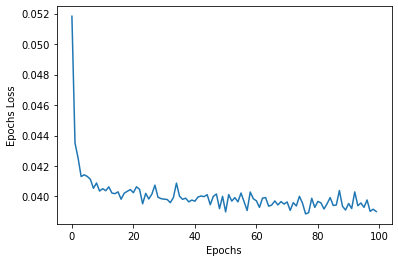

In [ ]:
def main():
    
    model, epochs_loss = run()
    
    # plot loss in each epoch
    plt.plot(range(len(epochs_loss)), epochs_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Epochs Loss')
    
    return model
    
model = main()

# Visualize Denoising Test Set

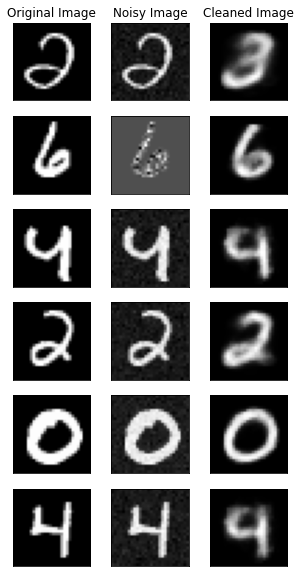

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f, axes= plt.subplots(6, 3, figsize = (5, 10))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Noisy Image")
axes[0,2].set_title("Cleaned Image")

for idx, (noisy, clean, label) in enumerate(test_dataloader):
    if idx > 5:
        break
    
    # denoising with DAE
    noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
    #noisy = noisy.to(device)
    output = model(noisy)
    
    # fix size
    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()
    
    noisy = noisy.view(1, 28, 28)
    noisy = noisy.permute(1, 2, 0).squeeze(2)
    #noisy = noisy.detach().cpu().numpy()

    clean = clean.view(1, 28, 28)
    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()
    
    # plot
    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(noisy, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    
    axes[idx, 0].set(xticks=[], yticks=[])
    axes[idx, 1].set(xticks=[], yticks=[])
    axes[idx, 2].set(xticks=[], yticks=[])

# Evaluation with Peak Signal to Noise Ratio (PSNR) Metric

In [ ]:
def evaluate(model, test_dataloader):
    psnr_noisy = []
    psnr_clean = []
    for noisy, original, label in tqdm(test_dataloader):
        # denoising with DAE
        noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
        #noisy = noisy.to(device)
        clean = model(noisy)

        # fix size
        clean = clean.view(1, 28, 28)
        clean = clean.permute(1, 2, 0).squeeze(2)
        clean = clean.detach().cpu().numpy()

        noisy = noisy.view(1, 28, 28)
        noisy = noisy.permute(1, 2, 0).squeeze(2)
        noisy = noisy.detach().cpu().numpy()

        original = original.view(1, 28, 28)
        original = original.permute(1, 2, 0).squeeze(2)
        original = original.detach().cpu().numpy()
        
        psnr_noisy.append(cv2.PSNR(noisy, original))
        psnr_clean.append(cv2.PSNR(clean, original))
        
    return np.mean(psnr_noisy), np.mean(psnr_clean)

In [ ]:
psnr_noisy, psnr_clean = evaluate(model, test_dataloader)

 23%|██▎       | 2296/10000 [00:02<00:08, 954.74it/s]

In [ ]:
print(f'PSNR improved from {psnr_noisy} for Noisy Images to {psnr_clean} for denoised images by DAE.')